## Introduction

`nonos` is a 2D visualization Python library, developed initially for planet-disk numerical simulations, as well as a command line application. It works with VTK-formatted data from IDEFIX and PLUTO, and dat-formatted data from FARGO-ADSG and FARGO3D. Most of the implementation has been made for polar / spherical outputs, even though some basic operations are possible in cartesian.

In this tutorial, we will learn how to: 
- load an IDEFIX dataset with `nonos.api.GasDataSet`
- perform some operations on a field (e.g., slices, projection)
- create a new field with `nonos.api.compute`
- visualize the data

## Resources

See the [documentation](https://nonos.readthedocs.io/en/latest/) for an introduction of nonos.

## Visualization from an Idefix point of view

### 1 - Loading a dataset

Get the path of the directory where you ran the planet test the first day (`.../idefix-days/tutorials/getting_started/PlanetMigration2D`), and import the following libraries (in particular `GasDataSet` from `nonos.api`)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from nonos.api import GasDataSet
from nonos.styling import set_mpl_style

set_mpl_style(1)  # not mandatory, just a custom style

In [2]:
directory = "/home/wafflarg/Documents/idefix-days/tutorials/getting_started/PlanetMigration2D"  # CHANGE TO YOUR PATH!
on = 9
# load the VTK file data.{on:04d}.vtk in the dataset ds
ds = GasDataSet(on, directory=directory)

`ds` is a field container, and you can access the fields in the form of a dictionary. You can check what fields are included in `ds` by running:

In [3]:
list(ds.keys())

['PRS', 'RHO', 'VX1', 'VX2', 'VX3']

In [4]:
ds, ds["RHO"]

(<nonos.api.analysis.GasDataSet at 0x7d963c83e910>,
 <nonos.api.analysis.GasField at 0x7d963bfe3f10>)

`ds["RHO"]` has been created using the `GasField` class

### 2 - Accessing the data and performing operations

#### 2.1 - Geometry & coordinates

For this dataset, the simulation is in polar coordinates ($R$, $\phi$, $z$):

In [5]:
print(f"{ds.native_geometry}: {ds.coords.cube}")

polar: ('R', 'phi', 'z')


You can therefore have access to a 1D array of the coordinates in the simulation with `ds.coords.R`, `ds.coords.phi` and `ds.coords.z` for the cell edges and `ds.coords.Rmed`, `ds.coords.phimed`, `ds.coords.zmed` for the cell centers.

In [6]:
ds.coords.R

array([0.42      , 0.42895833, 0.43791667, 0.446875  , 0.45583335,
       0.46479166, 0.47375   , 0.48270833, 0.49166667, 0.500625  ,
       0.50958335, 0.5185417 , 0.5275    , 0.5364583 , 0.54541665,
       0.554375  , 0.56333333, 0.5722917 , 0.58125   , 0.59020835,
       0.5991667 , 0.608125  , 0.6170833 , 0.62604165, 0.635     ,
       0.64395833, 0.65291667, 0.661875  , 0.67083335, 0.6797917 ,
       0.68875   , 0.6977083 , 0.70666665, 0.715625  , 0.7245833 ,
       0.73354167, 0.7425    , 0.75145835, 0.7604167 , 0.769375  ,
       0.7783333 , 0.78729165, 0.79625   , 0.8052083 , 0.81416667,
       0.823125  , 0.83208334, 0.8410417 , 0.85      , 0.8589583 ,
       0.86791664, 0.876875  , 0.8858333 , 0.89479166, 0.90375   ,
       0.91270834, 0.9216667 , 0.930625  , 0.93958336, 0.94854164,
       0.9575    , 0.9664583 , 0.97541666, 0.984375  , 0.99333334,
       1.0022917 , 1.01125   , 1.0202084 , 1.0291667 , 1.038125  ,
       1.0470834 , 1.0560417 , 1.065     , 1.0739583 , 1.08291

Note that the name of the coordinates depend on the geometry:
- cartesian : `ds.coords.x`, `ds.coords.y`, `ds.coords.z`
- spherical : `ds.coords.r`, `ds.coords.theta`, `ds.coords.phi`
- polar     : `ds.coords.R`, `ds.coords.phi`, `ds.coords.z`

#### 2.2 - Data

Concerning the data for the different fields including in the vtk, e.g. the density field `ds["RHO"]`, you can access it using `ds["RHO"].data`, which is basically a numpy array. You can therefore have access to useful information such as its shape:

In [7]:
ds["RHO"].data.shape

(192, 768, 1)

As we are in a `polar` geometry:
- The first axis corresponds to the radial ($R$) direction
- The second axis corresponds to the azimuthal ($\phi$) direction
- The third axis corresponds to the vertical ($z$) direction

#### 2.3 - Operations

Several operations can be made on the fields depending on the geometry, for example here you can perform an azimuthal average of the density.

In [8]:
# Azimuhtally averaged density field
ds["RHO"].azimuthal_average()

As you can see, it creates a new field with the same attributes as the original density field, but with a reduced dimension.

In [9]:
ds["RHO"].azimuthal_average().data.shape

(192, 1, 1)

The general operations that are available depending on the native geometry of the data are listed in the documentation on [this link](https://nonos.readthedocs.io/en/latest/api/#1-general-operations) (example: `radial_at_r(distance)` for a slice at a given radius, or `latitudinal_projection(theta)` for an integral between $-\theta$ and $\theta$)

#### 2.4 - Save and access reduced dataset

It is possible to save a reduced cube as a npy file, useful when post-processing huge VTK files in clusters for example. To do this, you can use the `save` method of the class `GasField`. It will:
- create a directory with the name of the field (ex : `rho`) containing all the reduced npy files corresponding to this field
- create a directory `header` containing a json file with important infos like the geometry and the coordinates
- copy the idefix.ini file

In [10]:
import tempfile
# create a temporary directory, here not to pollute the repo
temp_dir = tempfile.TemporaryDirectory()
radnpy = 1.5
# save the reduced cube in a npy file
ds["RHO"].radial_at_r(radnpy).save(temp_dir.name)

To load the reduced dataset `dsnpy`, you just need to add the `operation` argument with the corresponding reduction name (here `radial_at_r1.5`), and perform operations on the dataset as usual

In [11]:
# load a dataset that contains all existing npy files corresponding to a given operation for all the fields (here just one)
dsnpy = GasDataSet(on, operation=f"radial_at_r{radnpy}", directory=temp_dir.name)
# delete the temporary file + cleanup
temp_dir.cleanup()

The reduced dataset contains indeed less fields than the original full dataset (operation on the density):

In [12]:
print(f"fields in full dataset    : {list(ds.keys())}")
print(f"fields in reduced dataset : {list(dsnpy.keys())}")

fields in full dataset    : ['PRS', 'RHO', 'VX1', 'VX2', 'VX3']
fields in reduced dataset : ['RHO']


And their dimensions are reduced, as we performed a slice on the radial direction:

In [13]:
print(f"data shape in full dataset    : {ds['RHO'].shape}")
print(f"data shape in reduced dataset :   {dsnpy['RHO'].shape}")

data shape in full dataset    : (192, 768, 1)
data shape in reduced dataset :   (1, 768, 1)


### 3 - Compute a new field

In order to compute a new field from preexisting ones, you can use the `compute` function imported from `nonos.api`, which takes 3 arguments:
- the name of the new field
- the corresponding array
- a known field with similar structure as the new field 

For example, we can consider the azimuthal component of the gas velocity ($v_\phi$), with the flow corrected by the `"rotation"` of the grid in IDEFIX ($\Omega_{\rm grid}$, indicated in the idefix.ini, section `"Hydro"`) and considered in corotation with the planet number `0` (located in $R_p$, $\phi_p$), and therefore create a corrected field $v_\phi^C$

$v_\phi^C = v_\phi + R(\Omega_{\rm grid}-R_p^{-3/2})$

In [14]:
import os

import inifix

# load the parameters from idefix.ini
inifile = inifix.load(os.path.join(directory, "idefix.ini"))
# rotation of the grid in the idefix simulation (Omega_grid)
omegagrid = inifile["Hydro"]["rotation"]
# radial location of the planet
Rp = ds["RHO"].find_rp(0)

We used here [inifix](https://pypi.org/project/inifix/), which is a small Python library developed by Clément Robert to read and write 'ini' configuration files in the style of PLUTO and IDEFIX.

In [15]:
from nonos.api import compute

# 3D array of the radial coordinate
Rmed3d = ds.coords.Rmed[:, None, None]

vphifield = compute(
    field="VPHI",
    data=ds["VX2"].data + Rmed3d * (omegagrid - pow(Rp, -1.5)),
    ref=ds["VX2"],  # same structure as v_phi field
)

### 4. Visualize the data

Before plotting the data, we need to convert the field into an object that can be plotted. To do that, nonos will map the field from the native geometry of the outputs to a target geometry. For example, if the native geometry of the dataset is `polar` ($R$, $\phi$, $z$), you can map it (and then visualize it) in a polar plane ($R$, $\phi$), but also in a cartesian plane ($x$, $y$).

In [16]:
ds["RHO"].map("x", "y")

Note that here there is just one cell in the vertical direction, so you don't need to perform a vertical slice beforehand. But in a general 3D case, you need first to reduce the dimension with one or two operations, and then map the field in the target plane.

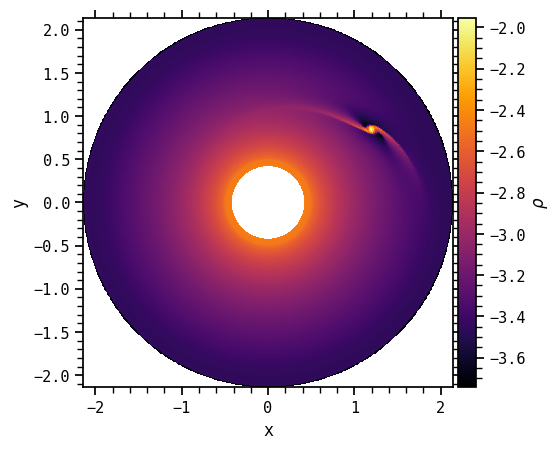

In [17]:
# Create figure and subplots with matplotlib.pyplot
fig, ax = plt.subplots()
# Density field mapped in the cartesian plane (x, y), and then plotted in log scale
ds["RHO"].map("x", "y").plot(fig, ax, log=True, cmap="inferno", title=r"$\rho$")
# Same scaling for x-axis and y-axis
ax.set(aspect="equal")
plt.show()

We have here a cartesian view of the density field, in log scale, using the colormap `"inferno"` and with a colorbar and title. We can do the same in a polar view.

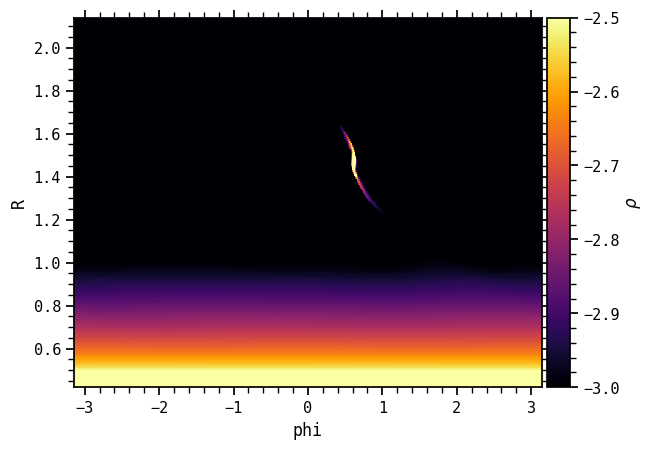

In [18]:
fig, ax = plt.subplots()
# Density field mapped in the polar plane (phi, R), and then plotted in log scale
ds["RHO"].map("phi", "R").plot(
    fig, ax, log=True, vmin=-3, vmax=-2.5, cmap="inferno", title=r"$\rho$"
)
plt.show()

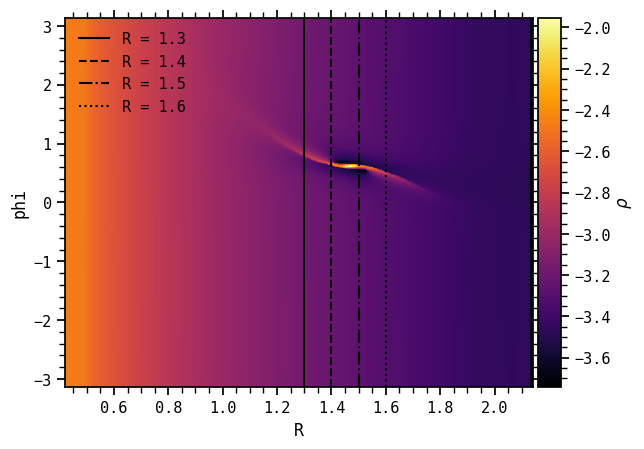

In [19]:
# Same here, but reversing the axes (phi, R) -> (R, phi)
# and superimposing other plots (vertical lines)
fig, ax = plt.subplots()
ds["RHO"].map("R", "phi").plot(fig, ax, log=True, cmap="inferno", title=r"$\rho$")
for rad, lsi in zip(np.linspace(1.3, 1.6, 4), ["-", "--", "-.", ":"]):
    ax.axvline(x=rad, c="k", ls=lsi, label=f"R = {rad:.1f}")
ax.legend(frameon=False, loc=2)
plt.show()

Here we added some vertical lines at different radial locations, and we can perform various slices at these locations in order to visualize the density field along these lines.

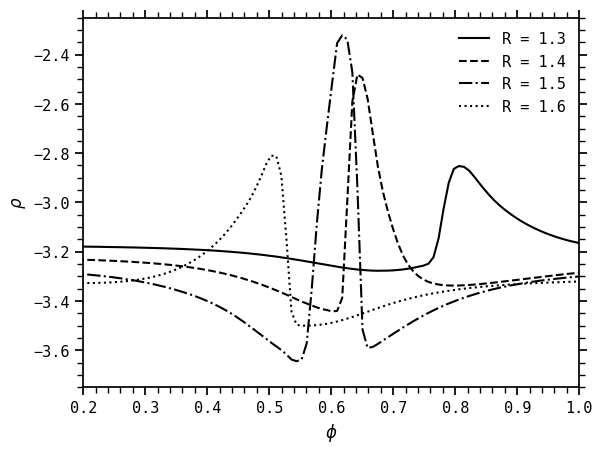

In [20]:
fig, ax = plt.subplots()
for rad, lsi in zip(np.linspace(1.3, 1.6, 4), ["-", "--", "-.", ":"]):
    ds["RHO"].radial_at_r(rad).map("phi").plot(
        fig, ax, log=True, title=r"$\rho$", c="k", ls=lsi, label=f"R = {rad:.1f}"
    )
ax.set(xlim=(0.2, 1), ylim=(-3.75, -2.25), xlabel=r"$\phi$")
plt.legend(frameon=False)
plt.show()

Note that we can perform exactly the same plotting with the reduced dataset `dsnpy`:

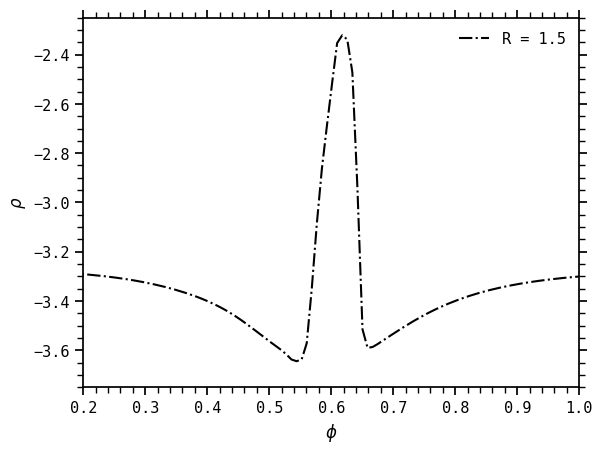

In [21]:
fig, ax = plt.subplots()
# using this time the reduced dataset saved previously
dsnpy["RHO"].map("phi").plot(fig, ax, log=True, title=r"$\rho$", c="k", ls="-.", label=f"R = {radnpy:.1f}")
ax.set(xlim=(0.2, 1), ylim=(-3.75, -2.25), xlabel=r"$\phi$")
plt.legend(frameon=False)
plt.show()

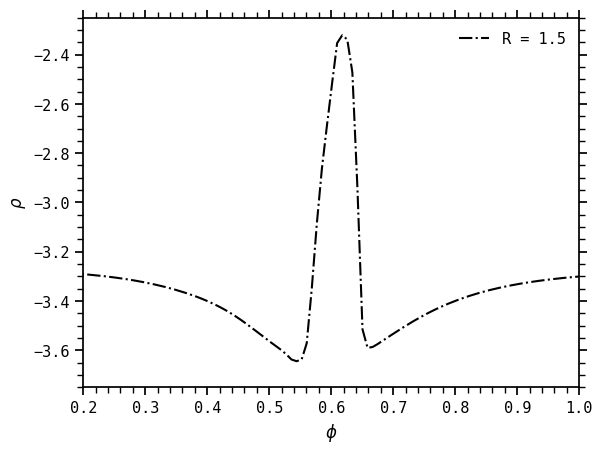

In [22]:
ig, ax = plt.subplots()
# using this time the reduced dataset saved previously
dsnpy["RHO"].map("phi").plot(fig, ax, log=True, title=r"$\rho$", c="k", ls="-.", label=f"R = {radnpy:.1f}")
ax.set(xlim=(0.2, 1), ylim=(-3.75, -2.25), xlabel=r"$\phi$")
plt.legend(frameon=False)
plt.show()

### 5. Bonus: Line Integral Convolution (LIC)

Here, we introduce the class `NonosLick` (not directly in the main library), and we can now use various functions and arguments that we introduced earlier, like `compute` or the coordinates at the cell center `ds.coords.Rmed`, `ds.coords.phimed`, and perform a Line Integral Convolution (method to visualize a vector field).

#### 5.1 Get the coordinates

In the next cell, we first convert from polar to cartesian the coordinates $(R, \phi) \rightarrow (x, y)$:

$x = R \cos(\phi)$ \
$y = R \sin(\phi)$

In [23]:
from nonos.api import NonosLick

# Radial and azimuthal coordinates
Rmed = ds.coords.Rmed
phimed = ds.coords.phimed
# 3D array of the azimuthal coordinate
pmed3d = phimed[None, :, None]

# Return a list of coordinate matrices from coordinate vectors.
RRmed, ppmed = np.meshgrid(Rmed, phimed, indexing="ij")
# Convert from polar to cartesian
xxmed = RRmed * np.cos(ppmed)
yymed = RRmed * np.sin(ppmed)

#### 5.2 Compute the data

Then we convert from polar to cartesian the the data $(v_R, v_\phi^C) \rightarrow (v_x, v_y)$:

$v_x = v_R \cos(\phi) - v_\phi^C \sin(\phi)$ \
$v_y = v_R \sin(\phi) + v_\phi^C \cos(\phi)$

In [24]:
# Compute v_x from (v_R, v_phi^C)
vxfield = compute(
    field="VX",
    data=ds["VX1"].data * np.cos(pmed3d) - vphifield.data * np.sin(pmed3d),
    ref=ds["VX1"],
)

# Compute v_y from (v_R, v_phi^C)
vyfield = compute(
    field="VY",
    data=ds["VX1"].data * np.sin(pmed3d) + vphifield.data * np.cos(pmed3d),
    ref=ds["VX1"],
)

#### 5.3 Perform the LIC

Then, we perform a LIC in a specific area around the planet:

In [25]:
# Define the area where we compute the LIC, and eventually the zoom of the final plot
xmin, xmax, ymin, ymax = (0.7, 1.7, 0.4, 1.3)

# LIC in cartesian, with the density field as background
lick = NonosLick(
    xxmed,
    yymed,
    vxfield,
    vyfield,
    ds["RHO"],
    xmin=xmin,
    xmax=xmax,
    ymin=ymin,
    ymax=ymax,
)

#### 5.4 Plot the LIC

Finally, we plot the LIC with some streamlines.

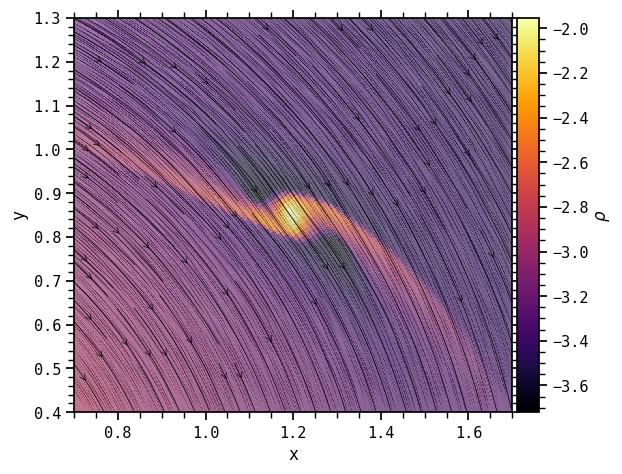

In [26]:
fig, ax = plt.subplots(figsize=(6, 8))
# Plot the density + LIC for the velocity vector
# with some streamlines. We are in corotation with the planet
lick.plot(fig, ax, log=True, title=r"$\rho$", density_streamlines=1, cmap="inferno")
ax.set(aspect="equal", xlim=(xmin, xmax), ylim=(ymin, ymax))
plt.show()